# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

Описание данных

<br>сalls — количество звонков,
<br>minutes — суммарная длительность звонков в минутах,
<br>messages — количество sms-сообщений,
<br>mb_used — израсходованный интернет-трафик в Мб,
<br>is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).


## Откройте и изучите файл

In [1]:
# загружаем используемые библиотеки

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.dummy import DummyClassifier

In [2]:
# зададим параметры
rd = 42 # random_state=42

In [3]:
# загрузим предоставленные данные

pth1 = 'datasets/users_behavior.csv'
pth2 = 'https://code.s3.yandex.net/datasets/users_behavior.csv'

if os.path.exists(pth1):
    data = pd.read_csv(pth1)
elif os.path.exists(pth2):
    data = pd.read_csv(pth2)
else:
    print('Something is wrong')

### Небольшой EDA

In [4]:
# Посмотрим на данные "общими мазками" по числовым данным
data.describe()


,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


Какого-либо аномалий не выявлено. Пропуской тоже нет. <br />
Посмотрим типы данных.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Типы данных тоже соответствуют. Посмотрим на каждый признак отдельно:

### Анализ Calls

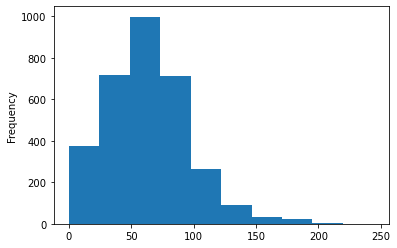

In [6]:
# посмотрим частоту звонков:
data.calls.plot(kind="hist");

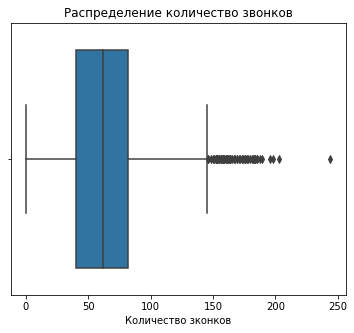

In [7]:
plt.figure(figsize=(6, 5));
ax=sns.boxplot(x = data.calls,)
ax.set()

plt.xlabel("Количество зконков");
plt.title('Распределение количество звонков')
plt.show();

### Анализ minutes

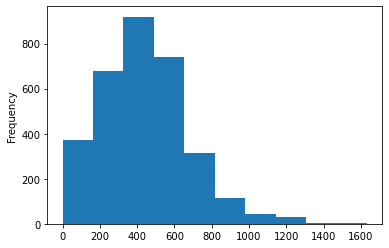

In [8]:
# посмотрим частоту минут:
data.minutes.plot(kind="hist");

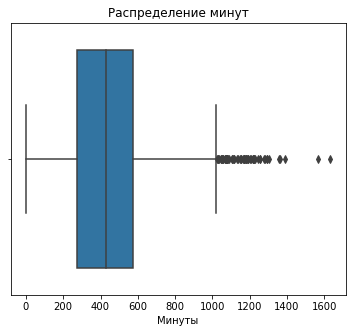

In [9]:
plt.figure(figsize=(6, 5));
ax=sns.boxplot(x = data.minutes,)
ax.set()

plt.xlabel("Минуты");
plt.title('Распределение минут')
plt.show();

### Анализ messages

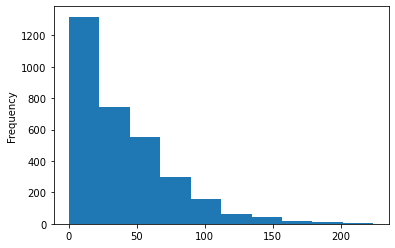

In [10]:
# посмотрим частоту сообщений:
data.messages.plot(kind="hist");

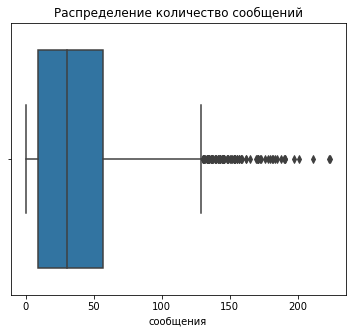

In [11]:
plt.figure(figsize=(6, 5));
ax=sns.boxplot(x = data.messages,)
ax.set()

plt.xlabel("сообщения");
plt.title('Распределение количество сообщений')
plt.show();

### Анализ mb_used

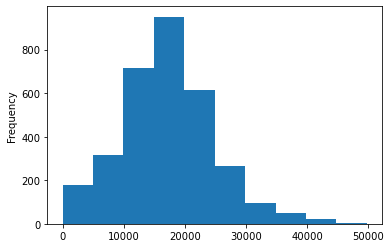

In [12]:
# посмотрим частоту использования интернет-траффика:
data.mb_used.plot(kind="hist");

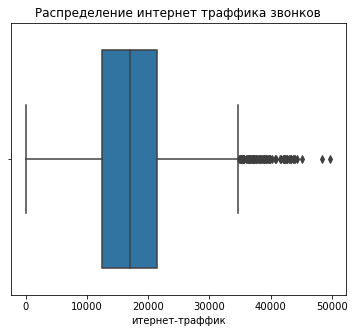

In [13]:
plt.figure(figsize=(6, 5));
ax=sns.boxplot(x = data.mb_used);
ax.set()

plt.xlabel("итернет-траффик");
plt.title('Распределение интернет траффика звонков')
plt.show();

### Анализ is_ultra

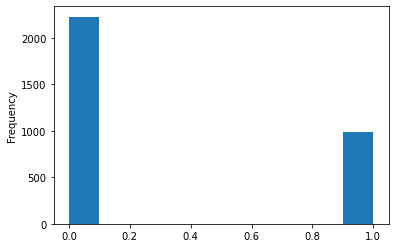

In [14]:
# посмотрим частоту сообщений:
data.is_ultra.plot(kind="hist");

### Корреляция

In [15]:
corr = data.corr()
corr.style.background_gradient(cmap='coolwarm')

,calls,minutes,messages,mb_used,is_ultra
calls,1.000000,0.982083,0.177385,0.286442,0.207122
minutes,0.982083,1.000000,0.173110,0.280967,0.206955
messages,0.177385,0.173110,1.000000,0.195721,0.203830
mb_used,0.286442,0.280967,0.195721,1.000000,0.198568
is_ultra,0.207122,0.206955,0.203830,0.198568,1.000000


Итоги быстрого EDA:
* пропусков нет. Ничего не меняем.
* в некоторых переменных есть выбросы. Их возможно удалить. Но по задании не трогаем их.
* корреляция с целевой функцией в районе 20%, что говорит о невысокой корреляции
* у целевой функции достаточной количество различных элементов для классификации: 2000+ значений "0", 1000+ значения "1"

## Разбейте данные на выборки

In [16]:
# подготовим данные целевой функции и для фичей.

X = data.drop(['is_ultra'], axis=1)
у = data['is_ultra']

display(X.head())
display(у.head())

,calls,minutes,messages,mb_used
0,40.0,311.90,83.0,19915.42
1,85.0,516.75,56.0,22696.96
2,77.0,467.66,86.0,21060.45
3,106.0,745.53,81.0,8437.39
4,66.0,418.74,1.0,14502.75


0    0
1    0
2    0
3    1
4    0
Name: is_ultra, dtype: int64

разобьем данные
* 60% - train set (_train),
* 20% - validation set(_val),
* 20% - test set (_test)

In [17]:
X_temp, X_val, у_temp, у_val = train_test_split(X, у, 
                                                test_size=0.2, train_size=0.8, 
                                                random_state=rd,
                                               stratify=у
                                               )

X_train, X_test, y_train, y_test = train_test_split(X_temp, у_temp, 
                                                    test_size = 0.25, train_size =0.75,
                                                    random_state=rd, 
                                                    stratify=у_temp
                                                   )

In [18]:
# проверим, что получилось:
print(len(X_train), len(y_train),
      len(X_test),len(y_test),
      len(X_val),len(у_val))

1928 1928 643 643 643 643


## Исследуйте модели

In [19]:
# создадим df для исследований
model_rep = pd.DataFrame({"model": [], "accuracy_score": []})
model_rep

,model,accuracy_score


### Логит-регрессия

In [20]:
LR_model = LogisticRegression()                                  # инициализация LR
LR_model.fit(X_train, y_train)                                   # тренировка 
pred_y_val = LR_model.predict(X_val)                           # предсказание функции на тесте                 

LR_accuracy = accuracy_score(y_test, pred_y_val)
LR_accuracy

0.6702954898911353

In [21]:
model_rep = model_rep.append({"model": 'LR_model', "accuracy_score": LR_accuracy},  ignore_index=True)
model_rep

C:\Users\izara\AppData\Local\Temp\ipykernel_9496\691363201.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_rep = model_rep.append({"model": 'LR_model', "accuracy_score": LR_accuracy},  ignore_index=True)


,model,accuracy_score
0,LR_model,0.670295


### Случайный лес

In [22]:
# пропишем гиперпараметры, которые будем перебирать

RFC_model = RandomForestClassifier()

RFC_params = {
    "n_estimators": [10, 100, 1000],
    "max_features": ['sqrt'],
    "max_depth": [5, 7, 10],
    "min_samples_split": [2, 4],
    "min_samples_leaf": [1, 2],
    "bootstrap": [False],
}

In [23]:
RFC_grid = GridSearchCV(RFC_model, RFC_params, cv=5)
RFC_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [False], 'max_depth': [5, 7, 10],
                         'max_features': ['sqrt'], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 4],
                         'n_estimators': [10, 100, 1000]})

In [24]:
RFC_grid.best_params_

{'bootstrap': False,
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 4,
 'n_estimators': 1000}

In [25]:
pred_y_val = RFC_grid.predict(X_val)                          # предсказание функции на val 

RFC_accuracy = accuracy_score(у_val, pred_y_val)
RFC_accuracy

0.8180404354587869

In [26]:
# добавим в общую таблицу
model_rep = model_rep.append({"model": 'RFC_grid', "accuracy_score": RFC_accuracy},  ignore_index=True)
model_rep

C:\Users\izara\AppData\Local\Temp\ipykernel_9496\2373827253.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_rep = model_rep.append({"model": 'RFC_grid', "accuracy_score": RFC_accuracy},  ignore_index=True)


,model,accuracy_score
0,LR_model,0.670295
1,RFC_grid,0.818040


ЛУчшие праметры в RCF:
'bootstrap': False,  'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 10

При таком небольшом количестве фичей (всего 4) получилось большое количество деревьев. =)

Глубина является одним из важнейших составляющих. Будем надеяться, что оверфита здесь не будет.

В логит-регрессии ACC=0.7200, а случайном лесе ACC=0.7791.
Учитывая ограниченность во времени и минимальную планку точность (0.7500), можно дальше модели не перебирать.

## Проверьте модель на тестовой выборке

In [27]:
# Проверим модель на тестовой выборке
# Так как у нас наилучая подель RFC_model, то будем смотреть на нее

pred_y_test = RFC_grid.predict(X_test)                          # предсказание функции на val 

RFC_accuracy = accuracy_score(y_test, pred_y_test)
RFC_accuracy

0.7869362363919129

На тестовых данных RFC показал результат 0,79. Результат на тесте ниже, чем результат на валидации. Результат 0,7900  приемлем для решения задачи.

## (бонус) Проверьте модели на адекватность

сделаем проверку на модели RFC. Для этого посмототрим 
<br> Для проверки сделаем предсказание для самым очевидных ситуаций: активношго пользователя и неактивного

* сalls 60 штук, 10 штук
* minutes 1000 минут, 10 минут
* messages 200 sms-сообщений, 0 sms-сообщений
* mb_used 500000 Мб, 0 Мб


In [28]:
X_rnd = pd.DataFrame({"calls": [60, 10], "minutes": [1000, 10], "messages": [200, 0], "mb_used": [50000, 0]})
pred_y_test = RFC_grid.predict(X_rnd)
pred_y_test

array([1, 1], dtype=int64)

В проверке на адекватность видно, что активному пользователю рекомендуется тарифный план Ультра. 
У пассивного пользователя наоброт - нет необходиомости и целесообразен тариф Смарт.

In [29]:
## DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.predict(X_train)
dummy_clf.score(X_train, y_train)

0.6934647302904564

Можно сделать вывод, что значение показателя 0,69 и оно далеко от 1,00. Значит такой дисбаланс в целевой функции не так критичен.

Вывод: Наилучшей точность из двух моделей: логистической регрессии и случайного леса обладает случайный лес. Подобраны оптимальные пераметры и достигнута минимальная необходимая точность с учетом подборов параметров.